In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Importing dataset
data = pd.read_csv('WineQT.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


Removing column Id as it is a unique identity for each entry and has no other contribution to the dataset

In [3]:
data.drop('Id', axis=1, inplace=True)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Checking whether our dataset contains any null values or not?

In [4]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

It's a good sign that our dataset doesn't contain any null value.

# Exploratory Data Analysis

Function to increase plot size

In [5]:
def big(x, y):
    """x = Width, y = Height"""
    plt.figure(figsize=(x, y))

As the dataset is based on wine quality, the column 'quality' is assumed to be our final column of interest. 

Percentage of unique values in the quality feature:

In [6]:
(data['quality'].value_counts() / len(data) ) * 100

5    42.257218
6    40.419948
7    12.510936
4     2.887139
8     1.399825
3     0.524934
Name: quality, dtype: float64

<AxesSubplot:>

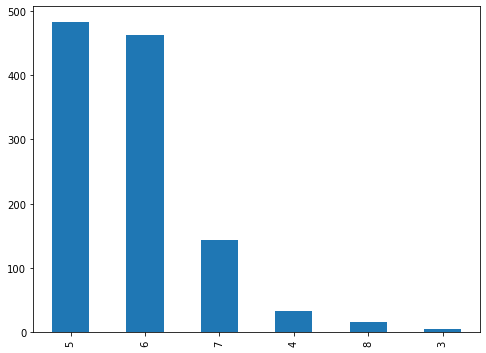

In [7]:
big(8, 6)
data['quality'].value_counts().plot(kind='bar')

As we can observe from the above bar plot, the majority of the wines (82%) are of average qualities (rating 5, 6). Only 12% of the wines are of best quality manufactured on the plant having a rating of 7 out of 10. Although, there are a few wines (55 / 1143) which has shows very poor features and can affect the training of the machine learning model at the later stage as model can be trained biased towards the other features. Keeping it as it is for now.

Checking the outliers in our dataset and dealing with them if there are any so that they don't affect our overall analysis and machine learning model later. 

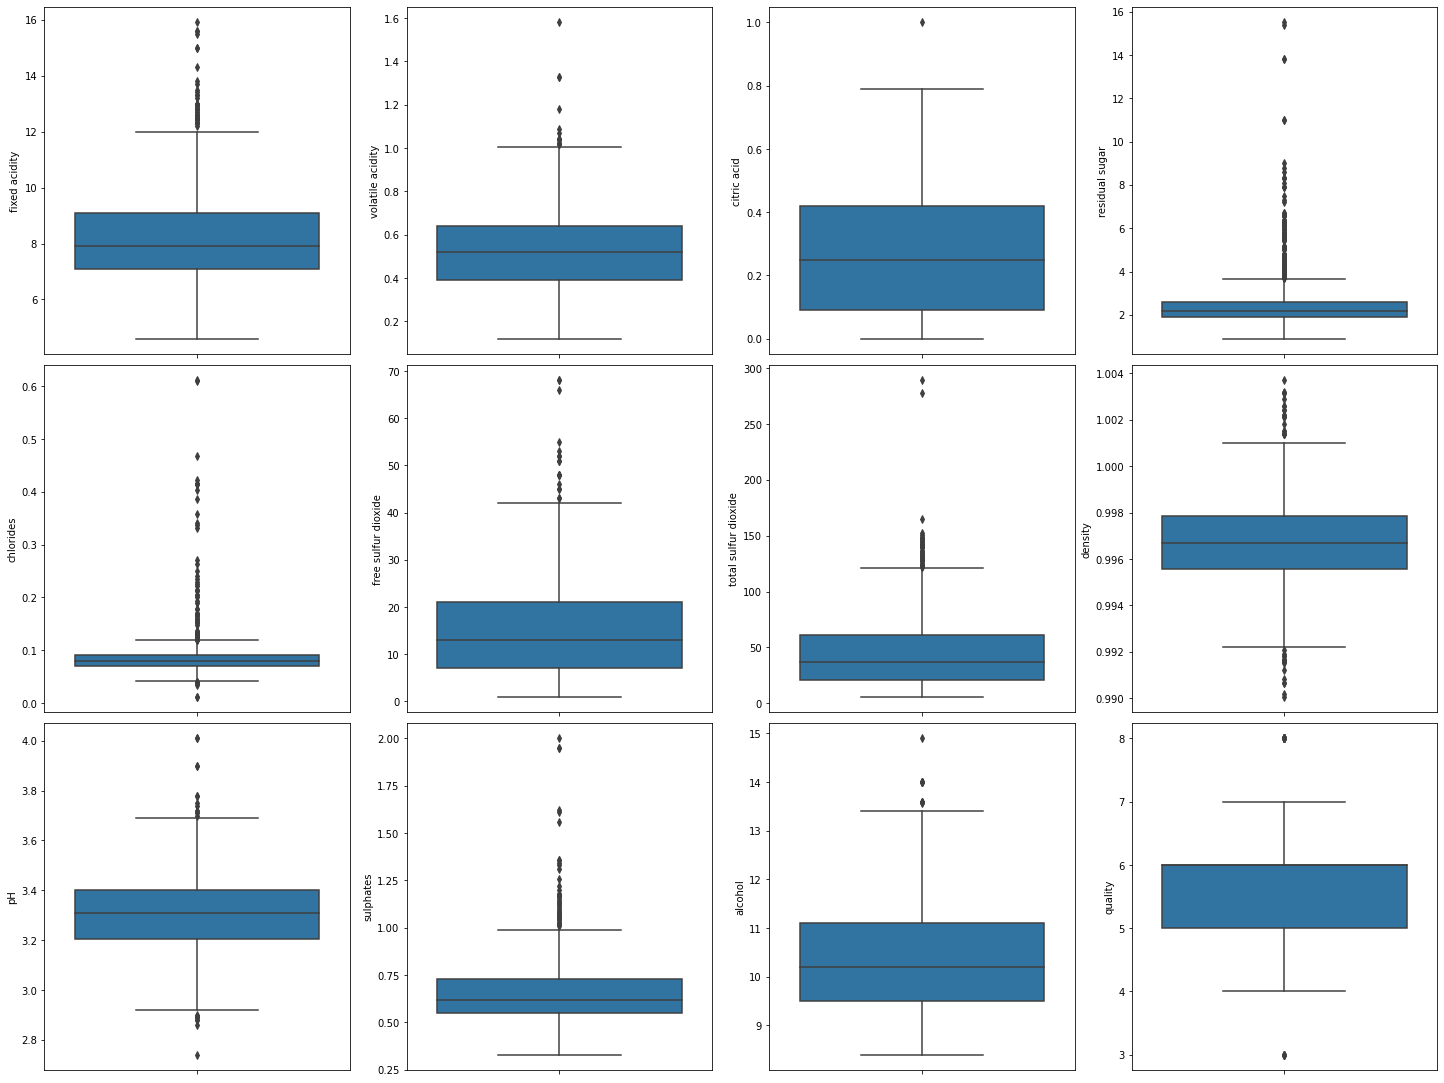

In [8]:
fig, ax = plt.subplots(ncols = 4, nrows = 3, figsize=(20,15))
i = 0
ax = ax.flatten()

for col, val in data.items():
    if col != 'type':
        sns.boxplot(y = col, data=data, ax = ax[i])
        i += 1

plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=0.5)

Box plots not only shows us the distribution of data but also the outliers if there are any in it. As we can observe from the visialisation above, there are several outliers but their difference distance with the max point is not at a concerning level. 

When we observe the range levels for each feature, only Total Sulphur Dioxide seems to have higher range due to outliers as most of the data is distributed below 70, so using log transformation to decrease the values.

In [9]:
data['total sulfur dioxide'] = np.log(1 + data['total sulfur dioxide'])

<AxesSubplot:xlabel='total sulfur dioxide', ylabel='Density'>

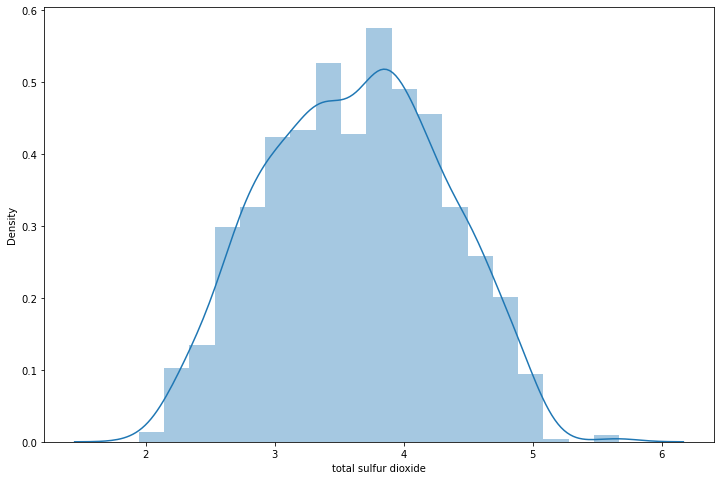

In [10]:
big(12,8)
sns.distplot(data['total sulfur dioxide'])

It's a good sign that there wasn't any additional need to remove the outliers and the feature looks balanced now after seeing the distribution of Total Sulphur Dioxide.

As there are plenty of features in the dataset on which the quality of wine is dependent, it's hard to choose one to start with so using a correlation matrix for identifying related columns. 

<AxesSubplot:>

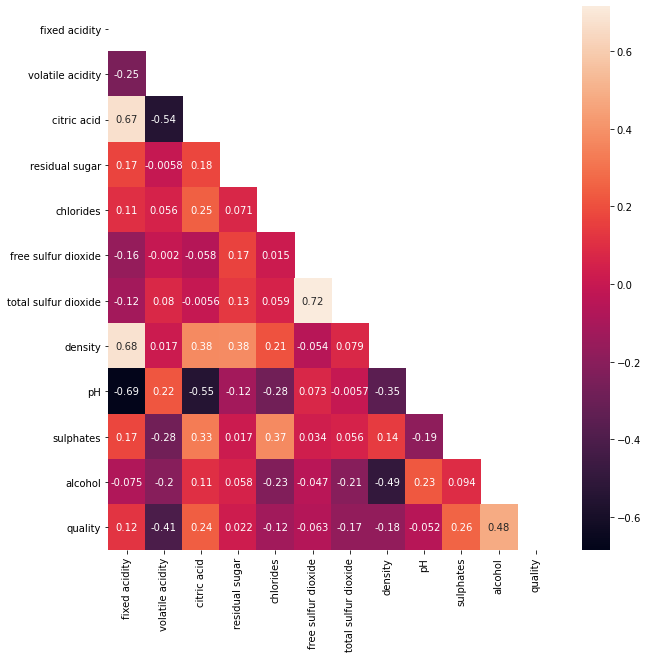

In [11]:
big(10, 10)
sns.heatmap(data=data.corr(), annot=True, mask=np.triu(data.corr()))

As we can observe from the above visualisation, there are various columns which are highly positive correlated and also highly negative correlated. 

Highly Positive Correlated - 

1. Free Sulfur Dioxide and Total Sulfur Dioxide
2. Fixed Acidity and Density
3. Fixed Acidity and Citric Acid
4. Alcohol and Quality

Highly Negative Uncorrelated - 

1. Fixed Acidity and pH
2. Citric Acid and pH
3. Volatile Acidity and Citric Acid
3. Density and Alcohol

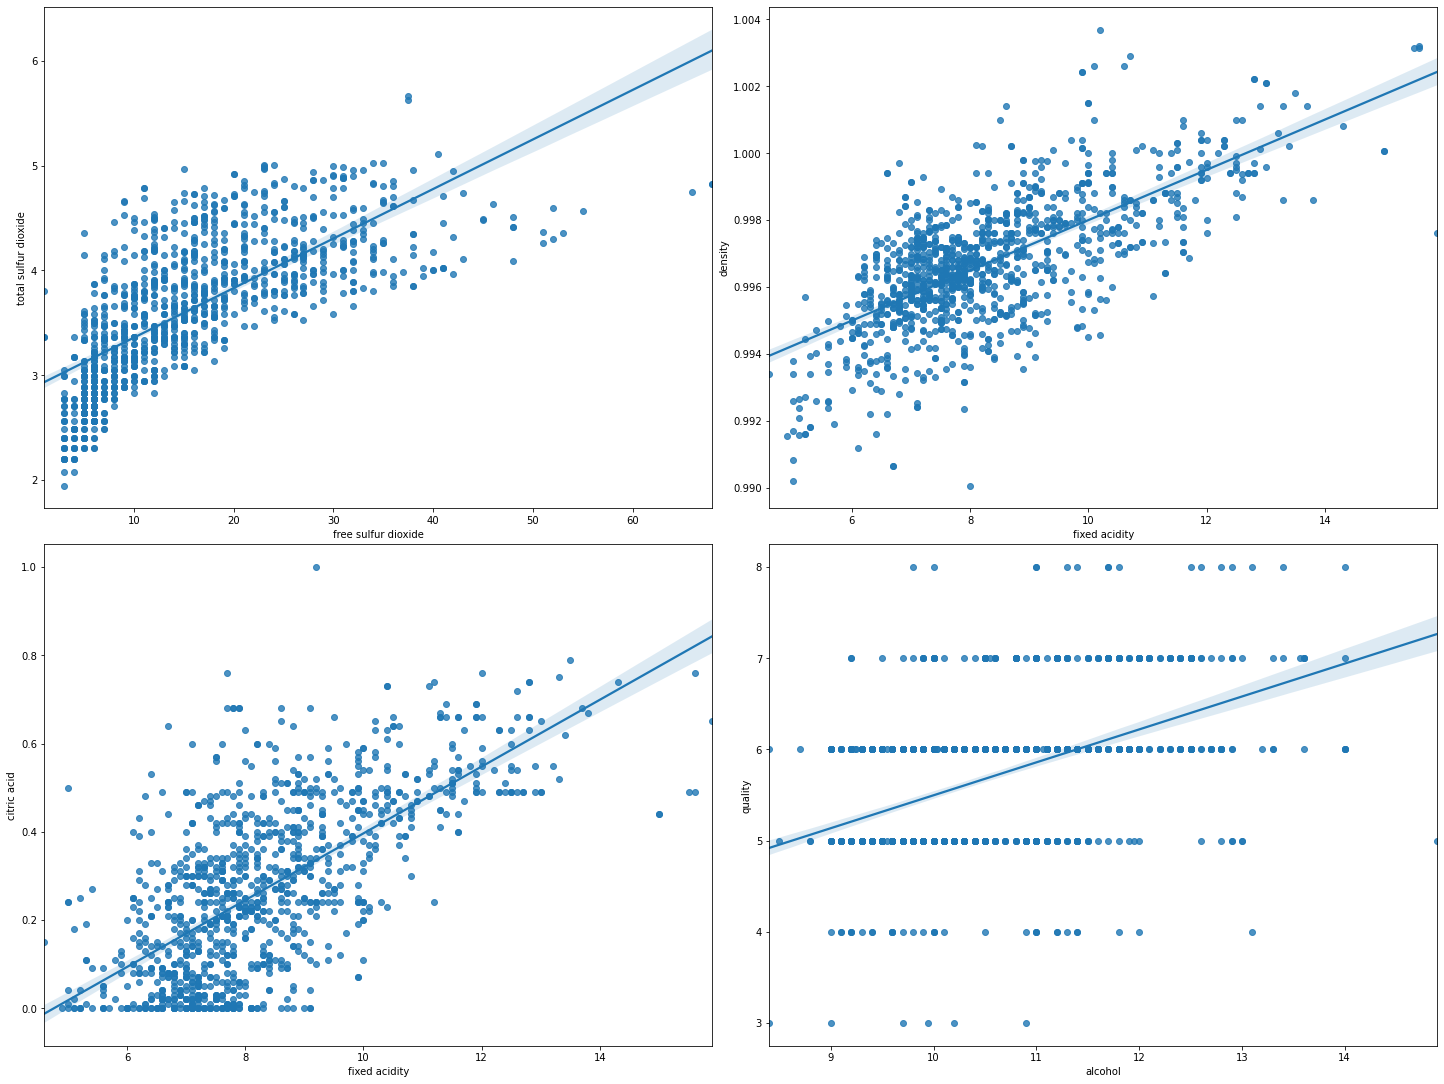

In [12]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(20,15))
i = 0
ax = ax.flatten()

sns.regplot(x = data['free sulfur dioxide'], y = data['total sulfur dioxide'], ax = ax[0])
sns.regplot(x = data['fixed acidity'], y = data['density'], ax = ax[1])
sns.regplot(x = data['fixed acidity'], y = data['citric acid'], ax = ax[2])
sns.regplot(x = data['alcohol'], y = data['quality'], ax = ax[3])

plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=0.5)

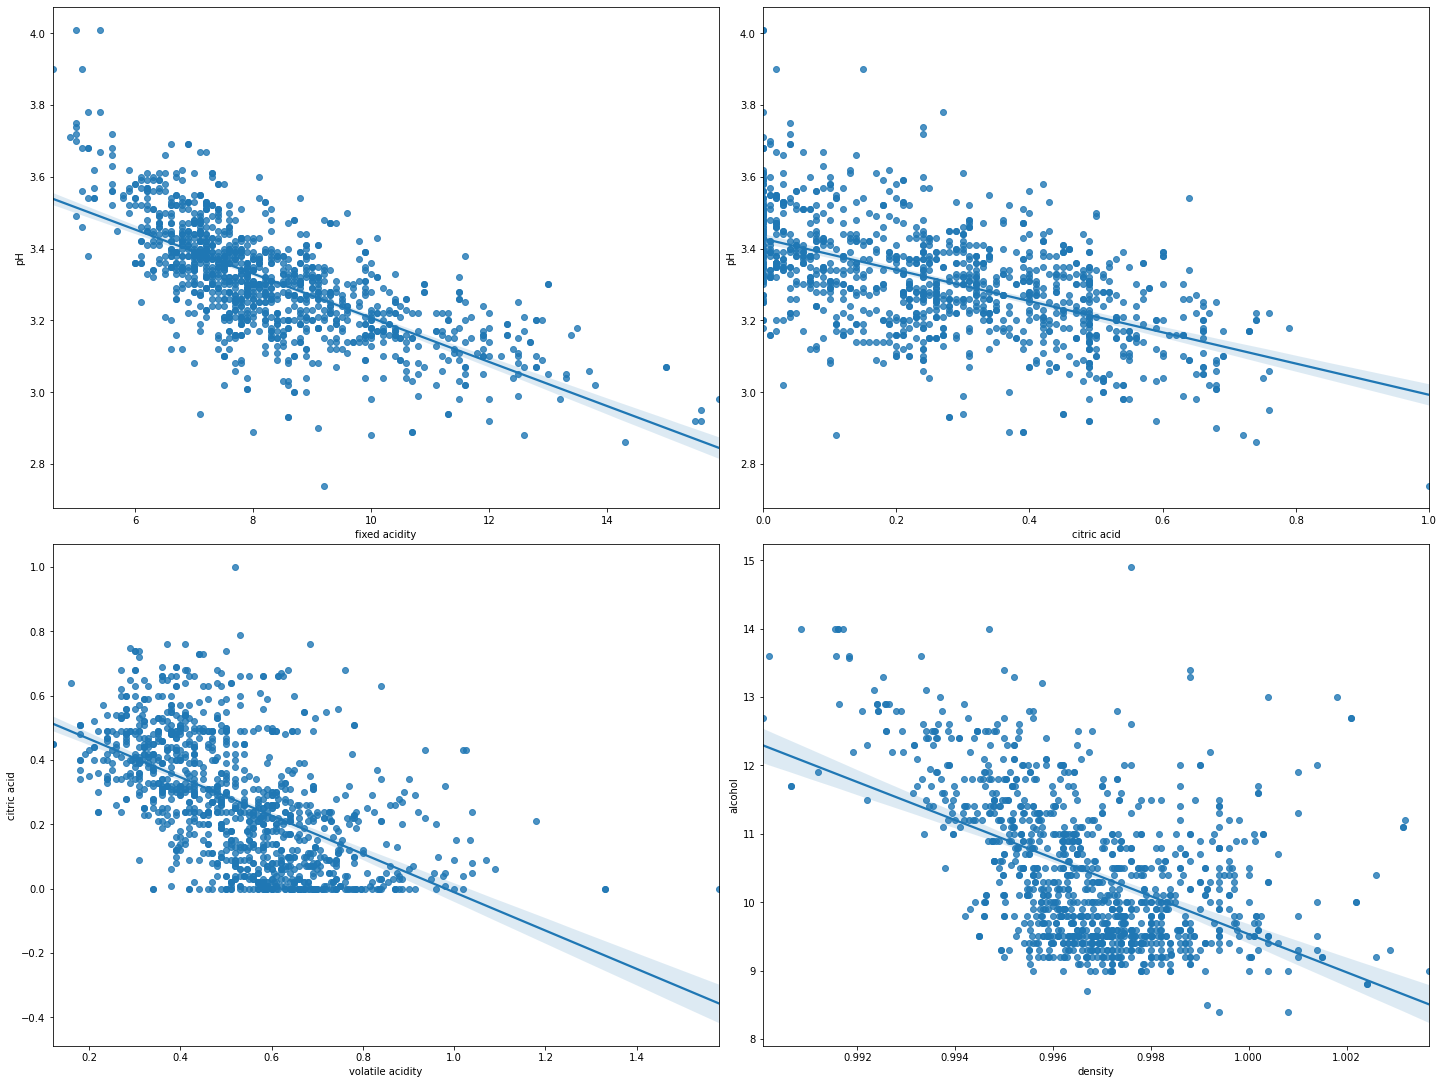

In [13]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(20,15))
i = 0
ax = ax.flatten()

sns.regplot(x = data['fixed acidity'], y = data['pH'], ax = ax[0])
sns.regplot(x = data['citric acid'], y = data['pH'], ax = ax[1])
sns.regplot(x = data['volatile acidity'], y = data['citric acid'], ax = ax[2])
sns.regplot(x = data['density'], y = data['alcohol'], ax = ax[3])

plt.tight_layout(pad = 0.5, w_pad=0.7, h_pad=0.5)

We can see in the regression plots on how they are correctly defining their respective correlation especially sulphor dioxides, alcohol, and quality. Before we move to the machine training part, here we have two choices:

1. For now consider the existing columns and ignoring the high correlations, train the model as every feature is important to wine and have to consider other aspects of data, quality of wine etc before we proceed to the removal of any one of them.

2. Since correlation can affect the model in some way and to increase the performance, we can remove a few columns to reduce the high correlation and further train the model with the remaining features. 

# Handling the distinct groups of wine 

As we have observed above in the value counts of unique quality values, it can be divided into two groups:

Good - Includes quality values 6, 7, 8.

Bad - Includes quality values 3, 4, 5. 

In [14]:
Y = data['quality'].apply(lambda y: 'good' if y > 5 else 'bad')
Y.head()

0     bad
1     bad
2     bad
3    good
4     bad
Name: quality, dtype: object

<AxesSubplot:>

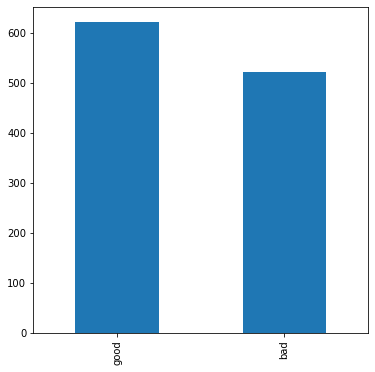

In [15]:
big(6, 6)
Y.value_counts().plot(kind='bar')

As we can see, the quality of the wine is now divided into two distinct group of wines 'Good' and 'Bad'. This also solved the issue of biasing which we were facing earlier where there were three quality groups having very less frequency of observational data. 

# Building Machine Learning model

Splitting the data into dependent and independent features:

In [16]:
X = data.iloc[:, :-1]

Train-test split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Since this is a classifier problem, there are many classification algorithms to choose from among which my preference would be Logistic Regression, Naive Bayes, Random Forest etc. As we have two unique featues Good and Bad, we can use Support Vector Machines as they are known for performing well with two labels by projecting them in the hyperplane. Here we also have to consider other important things such as higher number of dimensions due to which all the algorithms might not perform well except Random Forest so I will be implementing Random Forest Classifier. (The advantages and disadvantages of this algorithm is discussed at the end of this worksheet).

We also have a choice for using PCA to reduce the number of dimensions, but since our dataset is not very large, Random Forest should work fine omitting the need for using a dimentionality reduction algorithm. 

While using Random Forest, there can be a lot of hyper parameters to choose from to get the best out of models but there is a time limitation to try all the permutations and combinations using hit and trial method. So I'll be training Random Forest Classifier using Grid SearchCV saving time and getting the best model as output.

In [18]:
#Creating parameter grid
param_grid = { 'max_depth': [5, 8, 15, 25, 30],
               'n_estimators': [50, 80, 100, 200],
               'max_features': ['auto', 'sqrt', 'log2'],
               'criterion':['gini', 'entropy']
              }

In [19]:
#Base model
rf = RandomForestClassifier()

In [20]:
grid = GridSearchCV(rf, param_grid, cv = 3, verbose = 1, n_jobs=-1)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 8, 15, 25, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 80, 100, 200]},
             verbose=1)

Best Parameters to use in Random Forest

In [21]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 30,
 'max_features': 'auto',
 'n_estimators': 200}

Training and Predicting

In [35]:
o_rf = RandomForestClassifier(n_estimators=200,
                              max_depth=30,
                              min_samples_leaf=2,
                              min_samples_split=5,
                              criterion='entropy',
                              max_features='auto')
o_rf.fit(X_train, Y_train)
orf_p = o_rf.predict(X_test)

Classification Report

In [36]:
print(classification_report(Y_test, orf_p))

              precision    recall  f1-score   support

         bad       0.72      0.80      0.76       104
        good       0.82      0.74      0.78       125

    accuracy                           0.77       229
   macro avg       0.77      0.77      0.77       229
weighted avg       0.77      0.77      0.77       229



In [37]:
print(confusion_matrix(Y_test, orf_p))

[[83 21]
 [32 93]]


Accuracy is not a good measure to determine the model's performance as it can be misleading in some use cases. So how to know how our model did? Here comes the role of precision, recall, and f1-scores which are comprised on true positives, false positives and false negatives. For both the labels, model scores is near 78% approx, with good label having higher (because its observation vectors are higher than bad labels). 

Let's observe some more metrics.

Calculating probabilities for the predicted values

In [38]:
r_prob = [0 for _ in range(len(Y_test))]
rf_prob = o_rf.predict_proba(X_test)

Probabilities for only positive outcomes is kept

In [39]:
rf_prob = rf_prob[:, 1]

Encoding true test values for ROC Curve

In [40]:
y_t = []
for i in Y_test:
    if i == 'good':
        y_t.append(1)
    else:
        y_t.append(0)

Calculating the ROC ( Receiver Operating Curve ) and AUROC ( Area Under ROC )

In [41]:
r_auc = roc_auc_score(Y_test, r_prob)
rf_auc = roc_auc_score(Y_test, rf_prob)

In [42]:
print('Random (Chance) Prediction: AUROC = %.3f' % (r_auc))
print('Random Forest: AUROC = %.3f' % (rf_auc))

Random (Chance) Prediction: AUROC = 0.500
Random Forest: AUROC = 0.864


Calculating the True Positives and False Positives rates

In [43]:
r_fpr, r_tpr, _ = roc_curve(np.array(y_t) , np.array(r_prob))
rf_fpr, rf_tpr, _ = roc_curve(np.array(y_t) , np.array(rf_prob))

Visualising our ROC curve

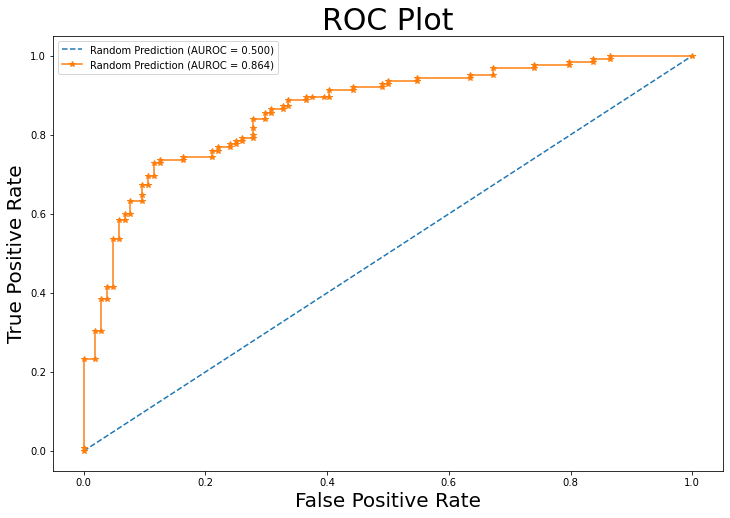

In [44]:
big(12, 8)
plt.plot(r_fpr, r_tpr, linestyle = '--', label = 'Random Prediction (AUROC = %0.3f)' % r_auc)
plt.plot(rf_fpr, rf_tpr, marker = '*', label = 'Random Prediction (AUROC = %0.3f)' % rf_auc)

plt.title('ROC Plot', size=30)
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.legend()
plt.show()

Since we had almost equal number of observations for both labels good and bad, ROC curve is the best measure to analyse our model's performance. It's a good sign that our model fitted optimally by observing the curve tilted more towards y-axis. Ofcourse, other measures can also be taken further to keep improving our model's performances. 

Apart from the ROC curves, Precision and Recall curves are also used but only when there is a moderate to large class imbalance which is false in our case. Reason for this is that ROC present an optimistic picture of the model on datasets with a class imbalance. 

For any machine learning model, we have to undergo several processes with all the precautions as slight error can lead to bad training of the model. 

Some advantages and disadvantages of Random Forest models are:

Advantages:

1. Robust to Outliers (As there were some in our data, which is handled by the model internally).
2. Lower Risk of Overfitting (worked well as shown in the ROC curve plot).
3. Efficient on large dataset. 
4. Better accuracy than other classification algorithms (As there are multiple decision trees are formed like a forest).

Disadvantages (Nothing is perfect):

1. Found to be biased while dealine with categorical values (There weren't any in the independent features).
2. Slow Training (For the very large datasets).
3. Not suitable for linear methods with a lot of sparse features. 

Future Work:

1. The data can be further optimised dealing with highly correlational features and other Feature Engineering techniques. 
2. Other appropriate classification models can be trained to compare the performances. 
3. If possible an Artificial Neural Network can be build for this classification problem. 
4. As there are six labels in the quality featre, we can also explore this problem using a Regressional approach. 

# Improving the model 

In [45]:
#Removing the highly-correlated columns: Fixed Acidity and free Sulphur Di Oxide

In [56]:
new = data.drop(['fixed acidity', 'free sulfur dioxide'], axis=1)
new.head(2)

,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.70,0.0,1.9,0.076,3.555348,0.9978,3.51,0.56,9.4,5
1,0.88,0.0,2.6,0.098,4.219508,0.9968,3.20,0.68,9.8,5


In [57]:
def new_d(new, Y, classifier):
    x = new.iloc[:, :-1]

    x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.2)

    nrf = classifier
    nrf.fit(x_train, y_train)
    nrfp = nrf.predict(x_test)

    print('\n',classification_report(y_test, nrfp))
    
    r_prob = [0 for _ in range(len(y_test))]
    rf_prob = nrf.predict_proba(x_test)
    
    rf_prob = rf_prob[:, 1]
    
    y_t = []
    for i in y_test:
        if i == 'good':
            y_t.append(1)
        else:
            y_t.append(0)
            
    r_auc = roc_auc_score(y_test, r_prob)
    rf_auc = roc_auc_score(y_test, rf_prob)
    
    print('\n Random (Chance) Prediction: AUROC = %.3f' % (r_auc))
    print('\n Random Forest: AUROC = %.3f' % (rf_auc))
    
    r_fpr, r_tpr, _ = roc_curve(np.array(y_t) , np.array(r_prob))
    rf_fpr, rf_tpr, _ = roc_curve(np.array(y_t) , np.array(rf_prob))
    
    big(12, 8)
    plt.plot(r_fpr, r_tpr, linestyle = '--', label = 'Random Prediction (AUROC = %0.3f)' % r_auc)
    plt.plot(rf_fpr, rf_tpr, marker = '*', label = 'Random Prediction (AUROC = %0.3f)' % rf_auc)

    plt.title('ROC Plot', size=30)
    plt.xlabel('False Positive Rate', size=20)
    plt.ylabel('True Positive Rate', size=20)
    plt.legend()
    plt.show()


               precision    recall  f1-score   support

         bad       0.74      0.78      0.76        99
        good       0.82      0.79      0.81       130

    accuracy                           0.79       229
   macro avg       0.78      0.79      0.78       229
weighted avg       0.79      0.79      0.79       229


 Random (Chance) Prediction: AUROC = 0.500

 Random Forest: AUROC = 0.859


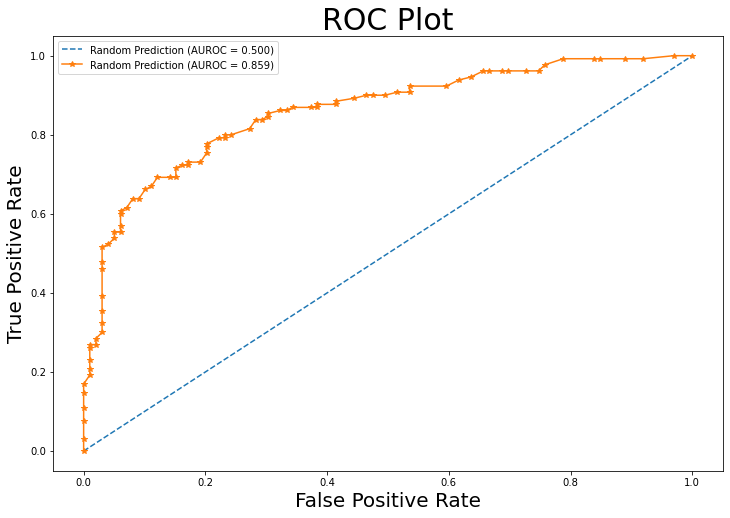

In [58]:
new_d(new, Y, RandomForestClassifier(random_state=0))

In [86]:
#Removing -ve correlated columns: Volatile acidity, citric acid
new1 = new.drop(['volatile acidity', 'citric acid', 'pH'], axis=1)
new1.head(2)

,residual sugar,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,1.9,0.076,3.555348,0.9978,0.56,9.4,5
1,2.6,0.098,4.219508,0.9968,0.68,9.8,5



               precision    recall  f1-score   support

         bad       0.74      0.72      0.73        97
        good       0.80      0.81      0.80       132

    accuracy                           0.77       229
   macro avg       0.77      0.77      0.77       229
weighted avg       0.77      0.77      0.77       229


 Random (Chance) Prediction: AUROC = 0.500

 Random Forest: AUROC = 0.837


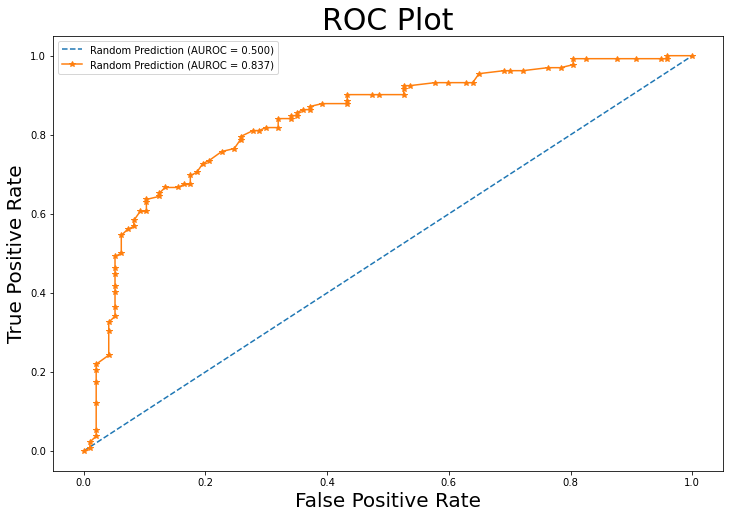

In [90]:
new_d(new1, Y, RandomForestClassifier(random_state=0))